# Deep models interpretability
This notebooks shows examples of approaches for interpretation of (pre-)trained model predictions.

In [1]:
try:
    import skimage
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'scikit-image'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import skimage

In [2]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

device: cuda


In [4]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [5]:
class_labels[897]

'washer'

### Task I: manual explanation with smoothgrad (2 points)

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [6]:
# model = torchvision.models.densenet121(pretrained=True).train(False).to(device)
model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 46.9MB/s]


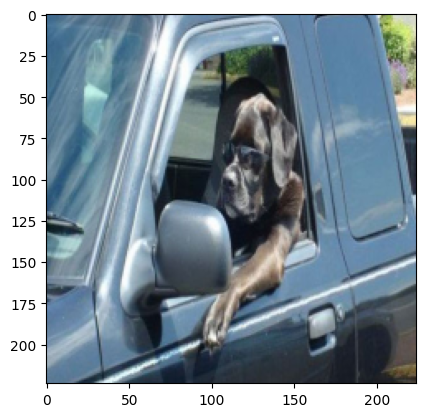

torch.Size([1, 1000])
#1: p=0.853	bloodhound (163)
#2: p=0.039	washer (897)
#3: p=0.009	car_mirror (475)
#4: p=0.008	pickup (717)
#5: p=0.008	Weimaraner (178)
#6: p=0.007	Labrador_retriever (208)
#7: p=0.006	Chesapeake_Bay_retriever (209)
#8: p=0.005	limousine (627)
#9: p=0.004	pug (254)
#10: p=0.003	tub (876)


In [16]:
!wget -q https://cdn2.adrianflux.co.uk/wp-fluxposure/uploads/2014/08/no-7.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)
    print(probs.shape)
    probs = probs[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

Now let's implement SmoothGrad itself.

In [12]:
t = torch.stack([torch.tensor([1]) for _ in range(5)], dim=0)
t =t.float()+ torch.rand((5,1)).float()
t

tensor([[1.3481],
        [1.0511],
        [1.3038],
        [1.4779],
        [1.1171]])

In [42]:
import gc
torch.cuda.empty_cache()
gc.collect()

17413

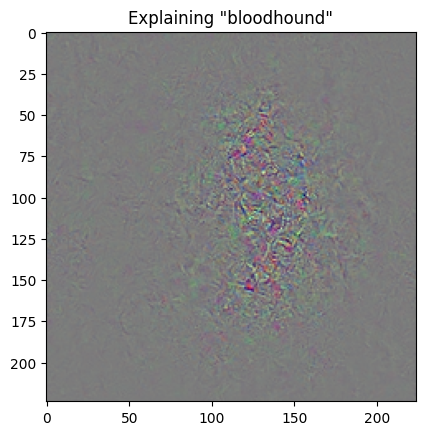

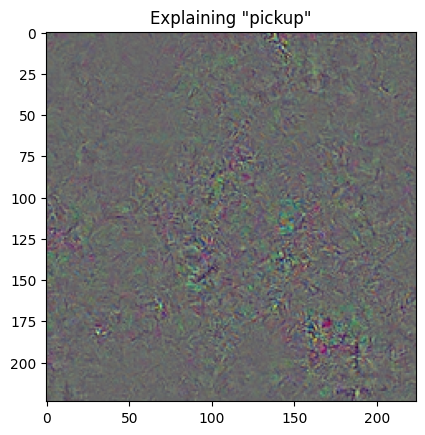

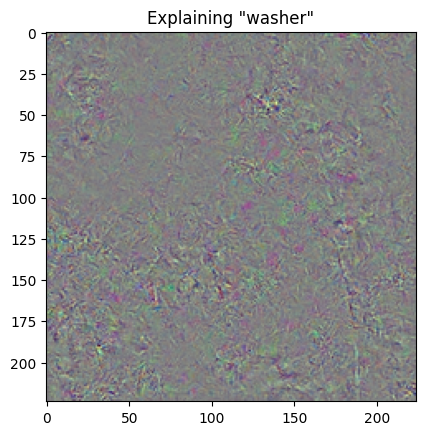

In [48]:
def explain_smoothgrad(image: torch.Tensor, class_ix, num_runs=32, sigma=0.1):
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)  # shape: [1, 3, h, w]

    # Create num_runs copies of an image
    copies = torch.stack([image_tensor[0].clone() for _ in range(num_runs)], dim=0)
    copies += torch.normal(mean=0.0, std=sigma, size=image_tensor.shape).to(device)

    # Ensure gradients can be computed
    copies.requires_grad_(True)

    # Compute logits and probabilities
    logits = model(copies.squeeze())  # Forward pass through the model
    probs = torch.softmax(logits, dim=-1)

    # Get probabilities for the desired class index
    class_probs = probs[:, class_ix]

    grads = []
    for i in range(num_runs):
        model.zero_grad()  # Clear previous gradients
        class_probs[i].backward(retain_graph=True)  # Compute gradients for each copy
        grads.append(copies.grad[i].detach().cpu())  # Store gradients

    # Average these gradients across different images
    average_gradients = torch.mean(torch.stack(grads), dim=0)

    # Reshape these gradients to the same shape as the original image: (h, w, 3)
    average_gradients = average_gradients.permute(1, 2, 0)  # shape: (h, w, 3)

    avg_grad_min = average_gradients.min()
    avg_grad_max = average_gradients.max()

    if avg_grad_max - avg_grad_min > 0:  # Prevent division by zero
        normalized_gradients = (average_gradients - avg_grad_min) / (avg_grad_max - avg_grad_min)
    else:
        normalized_gradients = average_gradients - avg_grad_min  # All values are the same

    return normalized_gradients.cpu().numpy()

for class_ix in 163, 717, 897:  # <-- insert your classes here, use numbers in (brackets)
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

__Let's try it out!__ Peter Higgs nobel prize photo

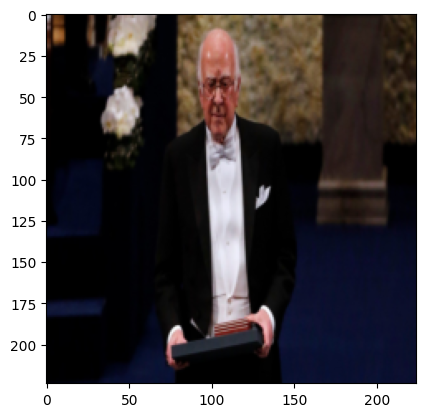

#1: p=0.211	suit (834)
#2: p=0.049	toilet_seat (861)
#3: p=0.040	plunger (731)
#4: p=0.032	vacuum (882)
#5: p=0.026	guillotine (583)
#6: p=0.024	balance_beam (416)
#7: p=0.023	academic_gown (400)
#8: p=0.022	torch (862)
#9: p=0.019	lab_coat (617)
#10: p=0.017	hook (600)


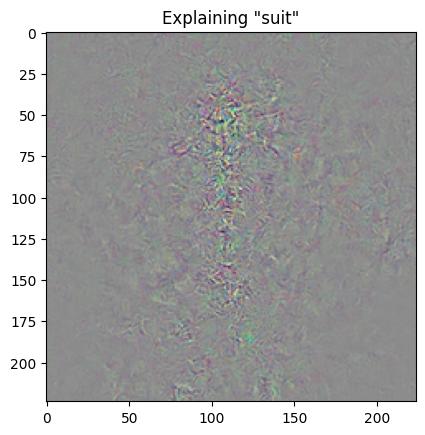

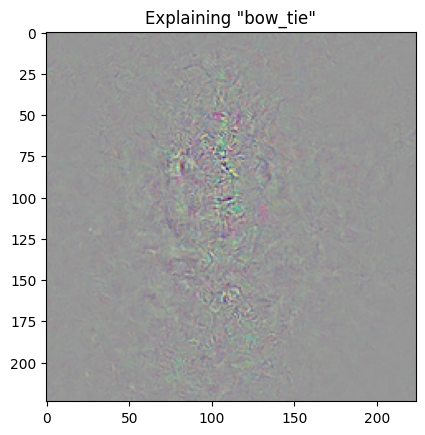

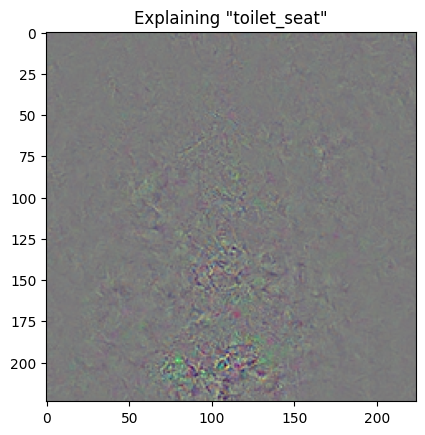

In [49]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

for class_ix in 834, 457, 861:
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

### SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [50]:
try:
    import shap
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'shap'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import shap

In [51]:
shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [52]:
background.size()

torch.Size([50, 3, 224, 224])

In [59]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

In [60]:
# explain and visualize. If you're not using a powerful V100 GPU, this may take up to 20 minutes.
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

KeyboardInterrupt: 

In [ ]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=3, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

###### Explaining classical machine learning models

Finally, let's see how SHAP explainers can be applied to more conventional machine learning models like gradient boosting.

Spoiler: exactly the same from a user's perspective. However, this time we're gonna use a different Shapley approximation implemented in TreeExplainer. For a full set of available explainers, take a look at their official [examples page](https://github.com/slundberg/shap/tree/master/notebooks).

**NB: the following cells requires JavaScript support and should work in Jupyter (not JupyterLab or cocalc)**.
In that case try running it on Google colab: https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb

In [62]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [69]:
import catboost # pip install catboost
import pandas as pd
shap.initjs()

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]))
y = raw_df.values[1::2, 2]

#X, y = shap.datasetsz.boston()
ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(X, y, verbose=False, plot=False)
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(X)

# visualize explanation of the first example
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

In [ ]:
# Explain training data: each *column* is a rotated plot from above, stacked for all training samples
# (this plot is interactive, hover mouse to see feature names)
shap.force_plot(explainer.expected_value, shap_values, X)

### Task II: Explain Intermediate Layers of Resnet50 on ImageNet (5 points)

Sometimes, computing explanations w.r.t. pixels is more difficult (and less interpretable) than using intermediate layers that are closer to the "output" layer. The trick is to compute low-resolution explanations of output w.r.t. intermediate layer and then resizing them to fit the original image.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to features like eyes and brows, and deeper layers capture entire objects.

**Your task** is to explain ResNet50 model outputs with respect to the convolution module from 2nd  and 4th layer of the pretrained Resnet50 network using the same GradientExplainer. *The task may require some googling or browsing the [docs](https://shap.readthedocs.io/en/latest) :)*

**Please use at least 10 images from across the internet (or from ImageNet) and compare the 2nd and 4th layer explanations on these images.**


In [ ]:
<YOUR CODE HERE>

## References

* SHAP explainer based on superpixels - [notebook](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html)
* SHAP reference notebook - [view on github](https://github.com/slundberg/shap/tree/master/notebooks)
* More various explainers in [ELI5](https://github.com/TeamHG-Memex/eli5)
* Same notebook on Google [Colab](https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb)